In [1]:
import os
import torch
import torchaudio
torchaudio.set_audio_backend("sox_io")
import pandas as pd
import numpy as np
import torch.nn.functional as F
import random
import scipy
import math
from scipy import signal
import librosa.display
import torch.nn as nn
from torch.utils.data import DataLoader

GAMMA = 1.25
DATA = 'ravdess_MFCC'
LAYERS = 1
ROOT = './Dataset/{}'.format(DATA)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
MODEL_PATH = './model/{}_DANN_{}L-CNN-GRU_DAP{}_CV'.format(DATA,LAYERS,GAMMA)
NPARR_PATH = './array/{}_DANN_{}L-CNN-GRU_DAP{}_CV accuracies.npz'.format(DATA,LAYERS,GAMMA)

In [2]:
def set_seed(sd):
    np.random.seed(sd)
    random.seed(sd)
    random.Random(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("Seed set to:{}".format(sd))
# also set worker_init_fn=np.random.seed(0),num_workers=0 in dataloader   

set_seed(42)

Seed set to:42


## 1. CV Dataset for Ravdess

In [3]:
class RavdessDataset2(object):
    """
        Create a Dataset for RAVDESS. Each item is a tuple of the form:
        (feature, emotion, speaker)
    """ 
    
    # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    _emotions = { '01': 0, '02': 1, '03': 2, '04': 3, '05': 4, '06': 5, '07': 6, '08': 7 }
 
    _speaker = {'0'+ str(i+1): i for i in range(24) if i< 9}
    _speaker.update({str(i+1): i for i in range(24) if i>= 9})

    
    def __init__(self, root, cv_index, split):
        """
        Args:
            root (string): Directory containing the wav files
            split(string): Either train, validate or test set
        """
        self.root = root
        self.data = []
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])
        self.allActors = ['0'+ str(i+1) for i in range(24)if i<9] + [str(i+1) for i in range(24)if i>=9]
        
        self.cv = { 0:  (['01','02'],['03','04']),
                    1:  (['03','04'],['05','06']),
                    2:  (['05','06'],['07','08']),
                    3:  (['07','08'],['09','10']),
                    4:  (['09','10'],['11','12']),
                    5:  (['11','12'],['13','14']),
                    6:  (['13','14'],['15','16']),
                    7:  (['15','16'],['17','18']),
                    8:  (['17','18'],['19','20']),
                    9:  (['19','20'],['21','22']),
                    10: (['21','22'],['23','24']),
                    11: (['23','24'],['01','02'])
                  }

        # Iterate through all audio files
        for root, dirs, files in os.walk(root):
            for file in files: 
                
                if split == 'train':
                    if file[-5:-3] in [x for x in self.allActors if x not in (self.cv[cv_index][0]+ self.cv[cv_index][1])]:
                        self.data.append([file[-5:-3],file[6:8],file])
                        
                elif split == 'validate':
                    if file[-5:-3] in self.cv[cv_index][0]:
                        self.data.append([file[-5:-3],file[6:8],file])
                        
                elif split == 'test':
                    if file[-5:-3] in self.cv[cv_index][1]:
                        self.data.append([file[-5:-3],file[6:8],file])
                else:
                    print("Error: Split can only be train, validate or test!")

        # Convert data to pandas dataframe
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])

        # Map emotion labels to numeric values
        self.df['Emotion'] = self.df['Emotion'].map(self._emotions).astype(np.long)
        self.df['Speaker'] = self.df['Speaker'].map(self._speaker).astype(np.long)

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        file_name = os.path.join(self.root, self.df.loc[idx, 'File'])
        feature = torch.load(file_name )
        emotion = self.df.loc[idx, 'Emotion']
        speaker = self.df.loc[idx, 'Speaker']
        
        # return a tuple instead of a dictionary
        sample = (feature,emotion,speaker)

        return sample

In [4]:
# # Initialize RavdessDataset
# ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = 4,split= 'train')
# ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = 4,split= 'test')
# ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = 4, split= 'validate')

# # To view dataframe, uncomment below: 
# ravdess_dataset_train.df

In [5]:
# from torch.utils.data import DataLoader
# TRAIN_BATCH_SIZE = 16
# VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
# TEST_BATCH_SIZE = len(ravdess_dataset_test)
# ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)

In [6]:
# next(iter(ravdess_train_loader))

## 2. Network Architectures and Helper Functions

### 2.1 Network Architectures

In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        # For same padding, P = ((S-1)*W-S+F)/2, with F = filter size, S = stride. If stride = 1, P = (F-1)/2
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, 2),padding=1,bias=False),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
                     
        )
        
        self.GRU = nn.GRU(input_size= 640, hidden_size = 256 ,batch_first = True, bidirectional = True) #128
        self.FC = nn.Linear(in_features = 512, out_features = 512) 
        
        
    def forward(self,x):
        x = self.conv_layers(x)
        # print("1-LFLB shape: {}".format(x.shape))                     # batch_size, c_out, freq, time 
        x = x.view(x.size(0),-1,x.size(3)) 
        # print("Batch size, features, seq shape: {}".format(x.shape))  # batch_size, features= c_out* freq , seq_len= time
        x = x.permute(0,2,1)
        # print("Batch size, seq, features shape: {}".format(x.shape))  # batch_size, seq, features
        output, hn = self.GRU(x)
        # print("GRU output shape: {}".format(output.shape))            # batch_size, seq, hidden size * 2 
        x = self.FC(output)
        # print("FC shape: {}".format(x.shape)) # 32 * 141 * 512
        mean = torch.mean(x,1) # 32 * 512
        stdev = torch.std(x,1) # 32 * 512
        x = torch.cat((mean,stdev),1)
        #print("Statistical pooling shape: {}".format(x.shape)) # 32 * 1024

        return x


In [8]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(128, 8),

        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


In [9]:
class SpeakerClassifier(nn.Module):
    def __init__(self):
        super(SpeakerClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(128, 24),
        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


### 2.2 Helper Functions

In [10]:
import numpy as np

def domain_adaptation_parameter(p):
    lambda_p = 2. / (1. + np.exp(-GAMMA*p)) - 1
    return lambda_p

In [11]:
def save_parameters(PATH):
    torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'emotion_classifier_state_dict': emotion_classifier.state_dict(),
                'speaker_classifier_state_dict': speaker_classifier.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'emotion_optimizer_state_dict': emotion_optimizer.state_dict(),
                'speaker_optimizer_state_dict': speaker_optimizer.state_dict(),
                }, PATH)
    print("Models' parameters and optimisers' parameters saved.")

In [12]:
def save_accuracies_and_losses(PATH):
    np.savez(PATH, 
         emoClassLoss = fold_emotion_class_losses,
         emoTrain_acc = fold_emotion_training_accuracies, 
         emoValidate_acc = fold_emotion_validating_accuracies,
         spkClassLoss = fold_speaker_class_losses,
         spkTrain_acc = fold_speaker_training_accuracies,
         spkValidate_acc = fold_speaker_validating_accuracies,
        
    )

## 4. Model Training

In [13]:
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
import pylab as plt

# Read this to understand how GRL works: 
# https://christineai.blog/category/domain-adaptation/

FOLDS = 12
EPOCHS = 100

############### To comment this section out if disrupted #############
fold_emotion_class_losses = np.zeros((FOLDS,EPOCHS))
fold_emotion_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_emotion_validating_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_class_losses = np.zeros((FOLDS,EPOCHS))
fold_speaker_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_validating_accuracies = np.zeros((FOLDS,EPOCHS))


######### To uncomment if trying to continue disrupted training ######
# fold_emotion_class_losses, fold_emotion_training_accuracies, fold_emotion_validating_accuracies， fold_speaker_class_losses，fold_speaker_training_accuracies，fold_speaker_validating_accuracies= np.load(NPARR_PATH)

###################################################################

# 12-fold cross validation
for fold in range(0,FOLDS):

    # Selecting CPU or GPU
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # DEVICE = torch.device("cpu")

    # Selecting the type of encoder, label classifier
    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE).train()

    # Optimizer 
    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())

    cross_entropy_loss = nn.CrossEntropyLoss().to(DEVICE)
    
    ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = fold ,split= 'train')
    ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = fold, split= 'test')
    ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = fold, split= 'validate')
    
    # DANN should be trained on labelled data from the source domain and unlabelled data from the target domain
    TRAIN_BATCH_SIZE = 32
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=True,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    # For evaluation purposes
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    epoch_emotion_class_losses = []
    emotion_training_accuracies = []
    emotion_validating_accuracies = []

    epoch_speaker_class_losses = []
    speaker_training_accuracies = []
    speaker_validating_accuracies = []

    STEP = 0
    for epoch in range(EPOCHS):
        print("\nCurrent Fold: {} | Epoch: {}".format(fold, epoch))

        completed_start_steps = epoch * len(ravdess_train_loader)
        total_steps = EPOCHS * len(ravdess_train_loader)

        batch_emotion_class_losses = []
        batch_speaker_class_losses = []


        for batch_idx, (feature, emotion, speaker) in enumerate(ravdess_train_loader):

            # Assigned to DEVICE. 
            features, emotion, speaker = feature.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE)
            
            # Computing the training progress
            p = (batch_idx + completed_start_steps) / total_steps
            lambda_p = domain_adaptation_parameter(p)

            # Calculate speaker and emotion classification prediction 
            conv_features = encoder(features)
            emotion_preds = emotion_classifier(conv_features)
            emotion_class_loss = cross_entropy_loss(emotion_preds, emotion)
            speaker_preds = speaker_classifier(conv_features)
            speaker_class_loss = cross_entropy_loss(speaker_preds, speaker)

            # Calculate total loss
            total_loss = emotion_class_loss - lambda_p * speaker_class_loss 

            # Clear the gradient to prevent gradient accumulation
            encoder.zero_grad(set_to_none= True)
            emotion_classifier.zero_grad(set_to_none= True)
            speaker_classifier.zero_grad(set_to_none= True)

            # Computing the gradient
            total_loss.backward()

            # Update the weight
            emotion_optimizer.step()
            speaker_optimizer.step()
            encoder_optimizer.step()

            batch_emotion_class_losses.append(emotion_class_loss.detach())
            batch_speaker_class_losses.append(speaker_class_loss.detach())


        # Enter evaluation mode at the end of each epoch
        encoder.eval()
        emotion_classifier.eval()
        speaker_classifier.eval()

        emotion_training_correct, emotion_validating_correct, speaker_training_correct, speaker_validating_correct = 0 , 0 , 0 , 0

        with torch.no_grad():

        # 1. Training Classification
          for index, (features, emotion, speaker) in enumerate(ravdess_train_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_training_correct += (emotion_preds == emotion).sum() 
            speaker_training_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_training_accuracy = emotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
          emotion_training_accuracies.append(emotion_training_accuracy)
          speaker_training_accuracy = speaker_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
          speaker_training_accuracies.append(speaker_training_accuracy)
          print("Emotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(emotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
          print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(speaker_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100))

        # 2. Validating Classification
          for index, (features, emotion, speaker) in enumerate(ravdess_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_validating_correct += (emotion_preds == emotion).sum() 
            speaker_validating_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_validating_accuracy = emotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
          emotion_validating_accuracies.append(emotion_validating_accuracy)
          speaker_validating_accuracy = speaker_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
          speaker_validating_accuracies.append(speaker_validating_accuracy)
          print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(emotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
          print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(speaker_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100))

          if (len(emotion_validating_accuracies)> 1 and emotion_validating_accuracy >= max(emotion_validating_accuracies[:-1])):
                save_parameters(MODEL_PATH + 'fold' + str(fold))


        encoder.train()
        emotion_classifier.train()
        speaker_classifier.train()


        epoch_emotion_class_loss = torch.mean(torch.stack(batch_emotion_class_losses), dim=0)
        epoch_emotion_class_losses.append(epoch_emotion_class_loss)
        epoch_speaker_class_loss = torch.mean(torch.stack(batch_speaker_class_losses), dim=0)
        epoch_speaker_class_losses.append(epoch_speaker_class_loss)
        
    fold_emotion_class_losses[fold] = epoch_emotion_class_losses
    fold_emotion_training_accuracies[fold] = emotion_training_accuracies
    fold_emotion_validating_accuracies[fold] = emotion_validating_accuracies
    fold_speaker_class_losses[fold] = epoch_speaker_class_losses
    fold_speaker_training_accuracies[fold] = speaker_training_accuracies
    fold_speaker_validating_accuracies[fold] = speaker_validating_accuracies
    
    save_accuracies_and_losses(NPARR_PATH)
    
    
    



Current Fold: 0 | Epoch: 0
Emotion Training Correct: 303/1184 
Emotion Training Accuracy: 25.59122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 0 | Epoch: 1
Emotion Training Correct: 267/1184 
Emotion Training Accuracy: 22.55068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 0 | Epoch: 2
Emotion Training Correct: 376/1184 
Emotion Training Accuracy: 31.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 0 | Epoch: 3
Emotion 


Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 0 | Epoch: 25
Emotion Training Correct: 871/1184 
Emotion Training Accuracy: 73.56419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 0 | Epoch: 26
Emotion Training Correct: 930/1184 
Emotion Training Accuracy: 78.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 0 | Epoch: 27
Emotion Training Correct: 976/1184 
Emotion Training Accuracy: 82.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 67


Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 0 | Epoch: 50
Emotion Training Correct: 1048/1184 
Emotion Training Accuracy: 88.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 0 | Epoch: 51
Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 85/120 
Emotion Validating Accuracy: 70.83333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 52
Emotion Training Correct: 1120/1184 
Emotion Training Accuracy: 94.59459%
Speaker Training Correct: 0/1184 
Speaker Tra


Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 0 | Epoch: 75
Emotion Training Correct: 1152/1184 
Emotion Training Accuracy: 97.29730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 0 | Epoch: 76
Emotion Training Correct: 1123/1184 
Emotion Training Accuracy: 94.84797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 0 | Epoch: 77
Emotion Training Correct: 1148/1184 
Emotion Training Accuracy: 96.95946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct:


Current Fold: 1 | Epoch: 0
Emotion Training Correct: 353/1184 
Emotion Training Accuracy: 29.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 1 | Epoch: 1
Emotion Training Correct: 320/1184 
Emotion Training Accuracy: 27.02703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 23/120 
Emotion Validating Accuracy: 19.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 1 | Epoch: 2
Emotion Training Correct: 359/1184 
Emotion Training Accuracy: 30.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 1 | Epoch: 3
Emotion T


Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 25
Emotion Training Correct: 850/1184 
Emotion Training Accuracy: 71.79054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 1 | Epoch: 26
Emotion Training Correct: 868/1184 
Emotion Training Accuracy: 73.31081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 1 | Epoch: 27
Emotion Training Correct: 980/1184 
Emotion Training Accuracy: 82.77027%
Speaker Training Correct: 0/1184 
Speaker Traini


Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 1 | Epoch: 50
Emotion Training Correct: 1058/1184 
Emotion Training Accuracy: 89.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 1 | Epoch: 51
Emotion Training Correct: 1100/1184 
Emotion Training Accuracy: 92.90541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 1 | Epoch: 52
Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct:


Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 1 | Epoch: 75
Emotion Training Correct: 1136/1184 
Emotion Training Accuracy: 95.94595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 1 | Epoch: 76
Emotion Training Correct: 1150/1184 
Emotion Training Accuracy: 97.12838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 1 | Epoch: 77
Emotion Training Correct: 1129/1184 
Emotion Training Accuracy: 95.35473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct:


Current Fold: 2 | Epoch: 0
Emotion Training Correct: 310/1184 
Emotion Training Accuracy: 26.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 2 | Epoch: 1
Emotion Training Correct: 444/1184 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 2
Emotion Training Correct: 453/1184 
Emotion Training Accuracy: 38.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 29/120 
Speaker Validating A


Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 2 | Epoch: 25
Emotion Training Correct: 963/1184 
Emotion Training Accuracy: 81.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 2 | Epoch: 26
Emotion Training Correct: 852/1184 
Emotion Training Accuracy: 71.95946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 2 | Epoch: 27
Emotion Training Correct: 817/1184 
Emotion Training Accuracy: 69.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 42

Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 2 | Epoch: 51
Emotion Training Correct: 1120/1184 
Emotion Training Accuracy: 94.59459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 2 | Epoch: 52
Emotion Training Correct: 1116/1184 
Emotion Training Accuracy: 94.25676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 2 | Epoch: 53
Emotion Training Correct: 10


Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 2 | Epoch: 76
Emotion Training Correct: 1120/1184 
Emotion Training Accuracy: 94.59459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 2 | Epoch: 77
Emotion Training Correct: 1150/1184 
Emotion Training Accuracy: 97.12838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 2 | Epoch: 78
Emotion Training Correct: 1160/1184 
Emotion Training Accuracy: 97.97297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct:

Emotion Training Correct: 420/1184 
Emotion Training Accuracy: 35.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 2
Emotion Training Correct: 506/1184 
Emotion Training Accuracy: 42.73649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 3
Emotion Training Correct: 544/1184 
Emotion Training Accuracy: 45.94595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 22/

Emotion Training Correct: 799/1184 
Emotion Training Accuracy: 67.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 3 | Epoch: 26
Emotion Training Correct: 1000/1184 
Emotion Training Accuracy: 84.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 85/120 
Emotion Validating Accuracy: 70.83333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 3 | Epoch: 27
Emotion Training Correct: 942/1184 
Emotion Training Accuracy: 79.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 90/120 
Emotion Validating Accuracy: 75.00000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%
Models' parameters and optimisers' parameters saved.

Current 

Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 51
Emotion Training Correct: 1142/1184 
Emotion Training Accuracy: 96.45270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 94/120 
Emotion Validating Accuracy: 78.33333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 52
Emotion Training Correct: 1122/1184 
Emotion Training Accuracy: 94.76351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 91/120 
Emotion Validating Accuracy: 75.83333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 53
Emotion Training Correct: 11


Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 3 | Epoch: 76
Emotion Training Correct: 1169/1184 
Emotion Training Accuracy: 98.73311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 99/120 
Emotion Validating Accuracy: 82.50000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 77
Emotion Training Correct: 1167/1184 
Emotion Training Accuracy: 98.56419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 85/120 
Emotion Validating Accuracy: 70.83333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 3 | Epoch: 78
Emotion Training Correct: 1172/1184 
Emotion Training Accuracy: 98.98649%
Speaker Training Correct: 0/1184 
Speaker Trainin

Emotion Training Correct: 469/1184 
Emotion Training Accuracy: 39.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 2
Emotion Training Correct: 471/1184 
Emotion Training Accuracy: 39.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 27/120 
Emotion Validating Accuracy: 22.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 4 | Epoch: 3
Emotion Training Correct: 464/1184 
Emotion Training Accuracy: 39.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%
Models' p


Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 26
Emotion Training Correct: 842/1184 
Emotion Training Accuracy: 71.11486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 27
Emotion Training Correct: 952/1184 
Emotion Training Accuracy: 80.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 4 | Epoch: 28
Emotion Training Correct: 932/1184 
Emotion Training Accuracy: 78.71622%
Speaker Training Correct: 0/1184 
Speaker Traini

Emotion Training Correct: 1146/1184 
Emotion Training Accuracy: 96.79054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 52
Emotion Training Correct: 1152/1184 
Emotion Training Accuracy: 97.29730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 53
Emotion Training Correct: 1038/1184 
Emotion Training Accuracy: 87.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct

Traceback (most recent call last):
  File "/home/bryan/miniconda3/envs/torch2/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/bryan/miniconda3/envs/torch2/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/bryan/miniconda3/envs/torch2/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/bryan/miniconda3/envs/torch2/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Emotion Training Correct: 1163/1184 
Emotion Training Accuracy: 98.22635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 4 | Epoch: 61
Emotion Training Correct: 1108/1184 
Emotion Training Accuracy: 93.58108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 4 | Epoch: 62
Emotion Training Correct: 1161/1184 
Emotion Training Accuracy: 98.05743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 4 | Epoch: 63
Emotion Training Correct: 11


Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 4 | Epoch: 86
Emotion Training Correct: 1169/1184 
Emotion Training Accuracy: 98.73311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 4 | Epoch: 87
Emotion Training Correct: 1169/1184 
Emotion Training Accuracy: 98.73311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 4 | Epoch: 88
Emotion Training Correct: 1169/1184 
Emotion Training Accuracy: 98.73311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct:


Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 11
Emotion Training Correct: 701/1184 
Emotion Training Accuracy: 59.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 5 | Epoch: 12
Emotion Training Correct: 546/1184 
Emotion Training Accuracy: 46.11486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 13
Emotion Training Correct: 810/1184 
Emotion Training Accuracy: 68.41216%
Speaker Training Correct: 0/1184 
Speaker Traini


Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 36
Emotion Training Correct: 983/1184 
Emotion Training Accuracy: 83.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 5 | Epoch: 37
Emotion Training Correct: 1047/1184 
Emotion Training Accuracy: 88.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 5 | Epoch: 38
Emotion Training Correct: 979/1184 
Emotion Training Accuracy: 82.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 6


Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 5 | Epoch: 61
Emotion Training Correct: 1136/1184 
Emotion Training Accuracy: 95.94595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 62
Emotion Training Correct: 1144/1184 
Emotion Training Accuracy: 96.62162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 63
Emotion Training Correct: 1146/1184 
Emotion Training Accuracy: 96.79054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct:

Emotion Training Correct: 1130/1184 
Emotion Training Accuracy: 95.43919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 87
Emotion Training Correct: 1146/1184 
Emotion Training Accuracy: 96.79054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 5 | Epoch: 88
Emotion Training Correct: 1160/1184 
Emotion Training Accuracy: 97.97297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 5 | Epoch: 89
Emotion Training Correct: 11

Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 11
Emotion Training Correct: 729/1184 
Emotion Training Accuracy: 61.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 12
Emotion Training Correct: 720/1184 
Emotion Training Accuracy: 60.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 13
Emotion Training Correct: 801/1184 
Emotion Training Accuracy: 67.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%


Emotion Training Correct: 954/1184 
Emotion Training Accuracy: 80.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 37
Emotion Training Correct: 880/1184 
Emotion Training Accuracy: 74.32432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 38
Emotion Training Correct: 1037/1184 
Emotion Training Accuracy: 87.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 39
Emotion Training Correct: 1025

Emotion Training Correct: 1111/1184 
Emotion Training Accuracy: 93.83446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 62
Emotion Training Correct: 1132/1184 
Emotion Training Accuracy: 95.60811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 63
Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Cur


Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 87
Emotion Training Correct: 1164/1184 
Emotion Training Accuracy: 98.31081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 88
Emotion Training Correct: 1153/1184 
Emotion Training Accuracy: 97.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 89
Emotion Training Correct: 1163/1184 
Emotion Training Accuracy: 98.22635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct:


Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 7 | Epoch: 12
Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 7 | Epoch: 13
Emotion Training Correct: 807/1184 
Emotion Training Accuracy: 68.15878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 14
Emotion Training Correct: 740/1184 
Emotion Training Accuracy: 62.50000%
Speaker Training Correct: 0/1184 
Speaker Trainin

Emotion Training Correct: 1005/1184 
Emotion Training Accuracy: 84.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 7 | Epoch: 37
Emotion Training Correct: 973/1184 
Emotion Training Accuracy: 82.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 7 | Epoch: 38
Emotion Training Correct: 989/1184 
Emotion Training Accuracy: 83.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 7 | Epoch: 39
Emotion Training Correct: 987/

Emotion Training Correct: 1113/1184 
Emotion Training Accuracy: 94.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 7 | Epoch: 62
Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 7 | Epoch: 63
Emotion Training Correct: 1123/1184 
Emotion Training Accuracy: 94.84797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 7 | Epoch: 64
Emotion Training Correct: 11

Emotion Training Correct: 1163/1184 
Emotion Training Accuracy: 98.22635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 7 | Epoch: 87
Emotion Training Correct: 1157/1184 
Emotion Training Accuracy: 97.71959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 7 | Epoch: 88
Emotion Training Correct: 1159/1184 
Emotion Training Accuracy: 97.88851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 7 | Epoch: 89
Emotion Training Correct: 11


Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 8 | Epoch: 11
Emotion Training Correct: 657/1184 
Emotion Training Accuracy: 55.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 12
Emotion Training Correct: 741/1184 
Emotion Training Accuracy: 62.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 8 | Epoch: 13
Emotion Training Correct: 762/1184 
Emotion Training Accuracy: 64.35811%
Speaker Training Correct: 0/1184 
Speaker Training 

Emotion Training Correct: 1034/1184 
Emotion Training Accuracy: 87.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 8 | Epoch: 36
Emotion Training Correct: 1034/1184 
Emotion Training Accuracy: 87.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 37
Emotion Training Correct: 1027/1184 
Emotion Training Accuracy: 86.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%
Models' parameters and optimisers' parameters saved.

Curr

Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 8 | Epoch: 61
Emotion Training Correct: 1144/1184 
Emotion Training Accuracy: 96.62162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 8 | Epoch: 62
Emotion Training Correct: 1134/1184 
Emotion Training Accuracy: 95.77703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 8 | Epoch: 63
Emotion Training Correct: 112

Emotion Training Correct: 1165/1184 
Emotion Training Accuracy: 98.39527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 8 | Epoch: 86
Emotion Training Correct: 1165/1184 
Emotion Training Accuracy: 98.39527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 87
Emotion Training Correct: 1172/1184 
Emotion Training Accuracy: 98.98649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%
Mode

Emotion Training Correct: 720/1184 
Emotion Training Accuracy: 60.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 9 | Epoch: 10
Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 11
Emotion Training Correct: 754/1184 
Emotion Training Accuracy: 63.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Curren

Emotion Training Correct: 931/1184 
Emotion Training Accuracy: 78.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 9 | Epoch: 35
Emotion Training Correct: 946/1184 
Emotion Training Accuracy: 79.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 9 | Epoch: 36
Emotion Training Correct: 995/1184 
Emotion Training Accuracy: 84.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%
Models' parameters and optimisers' parameters saved.

Curren

Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 9 | Epoch: 60
Emotion Training Correct: 1111/1184 
Emotion Training Accuracy: 93.83446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 9 | Epoch: 61
Emotion Training Correct: 1039/1184 
Emotion Training Accuracy: 87.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 9 | Epoch: 62
Emotion Training Correct: 11


Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 9 | Epoch: 85
Emotion Training Correct: 1104/1184 
Emotion Training Accuracy: 93.24324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 9 | Epoch: 86
Emotion Training Correct: 1162/1184 
Emotion Training Accuracy: 98.14189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 9 | Epoch: 87
Emotion Training Correct: 1153/1184 
Emotion Training Accuracy: 97.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct:

Emotion Training Correct: 654/1184 
Emotion Training Accuracy: 55.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 10 | Epoch: 10
Emotion Training Correct: 694/1184 
Emotion Training Accuracy: 58.61486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 10 | Epoch: 11
Emotion Training Correct: 687/1184 
Emotion Training Accuracy: 58.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 10 | Epoch: 12
Emotion Training Correct: 75

Emotion Training Correct: 1020/1184 
Emotion Training Accuracy: 86.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 10 | Epoch: 35
Emotion Training Correct: 975/1184 
Emotion Training Accuracy: 82.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 10 | Epoch: 36
Emotion Training Correct: 934/1184 
Emotion Training Accuracy: 78.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 10 | Epoch: 37
Emotion Training Correct: 1


Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 10 | Epoch: 60
Emotion Training Correct: 1142/1184 
Emotion Training Accuracy: 96.45270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 10 | Epoch: 61
Emotion Training Correct: 1096/1184 
Emotion Training Accuracy: 92.56757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 10 | Epoch: 62
Emotion Training Correct: 1143/1184 
Emotion Training Accuracy: 96.53716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 74


Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 10 | Epoch: 85
Emotion Training Correct: 1152/1184 
Emotion Training Accuracy: 97.29730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 10 | Epoch: 86
Emotion Training Correct: 1038/1184 
Emotion Training Accuracy: 87.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 10 | Epoch: 87
Emotion Training Correct: 1161/1184 
Emotion Training Accuracy: 98.05743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct

Emotion Training Correct: 647/1184 
Emotion Training Accuracy: 54.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 81/120 
Speaker Validating Accuracy: 67.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 10
Emotion Training Correct: 779/1184 
Emotion Training Accuracy: 65.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 72/120 
Speaker Validating Accuracy: 60.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 11
Emotion Training Correct: 763/1184 
Emotion Training Accuracy: 64.44257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct:

Emotion Training Correct: 940/1184 
Emotion Training Accuracy: 79.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 11 | Epoch: 35
Emotion Training Correct: 1046/1184 
Emotion Training Accuracy: 88.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 36
Emotion Training Correct: 1026/1184 
Emotion Training Accuracy: 86.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Cu

Emotion Training Correct: 1115/1184 
Emotion Training Accuracy: 94.17230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 11 | Epoch: 60
Emotion Training Correct: 1133/1184 
Emotion Training Accuracy: 95.69257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 11 | Epoch: 61
Emotion Training Correct: 1132/1184 
Emotion Training Accuracy: 95.60811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 11 | Epoch: 62
Emotion Training Correct:


Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 11 | Epoch: 85
Emotion Training Correct: 1148/1184 
Emotion Training Accuracy: 96.95946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 11 | Epoch: 86
Emotion Training Correct: 1114/1184 
Emotion Training Accuracy: 94.08784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 11 | Epoch: 87
Emotion Training Correct: 1155/1184 
Emotion Training Accuracy: 97.55068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%

Emotion Validating Corre

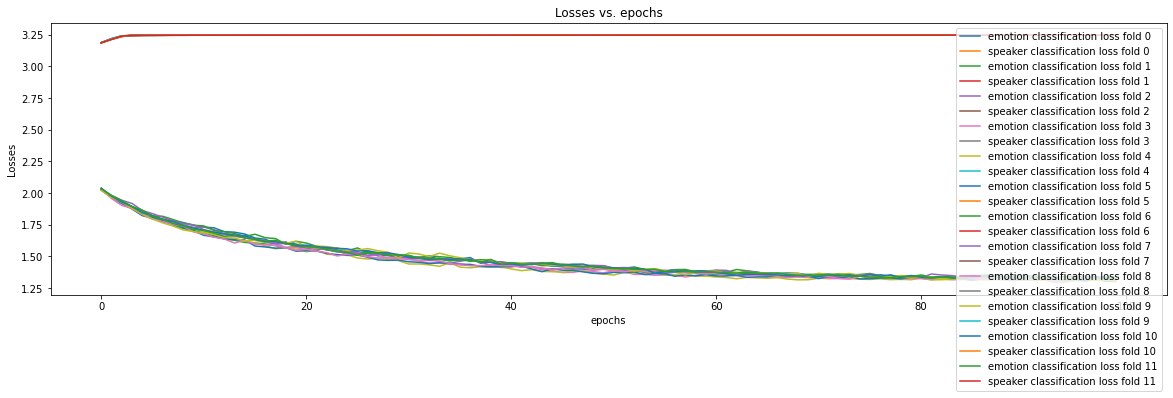

In [14]:
plt.figure(figsize=(20,5))
plt.title('Losses vs. epochs')
plt.xlabel('epochs')
plt.ylabel('Losses')

for i in range(FOLDS):
    plt.plot(range(EPOCHS), fold_emotion_class_losses[i],label='emotion classification loss fold {}'.format(i))
    plt.plot(range(EPOCHS), fold_speaker_class_losses[i],label='speaker classification loss fold {}'.format(i))

plt.legend(loc='best')
plt.show() 

In [15]:
def plot_accuracies_vs_epochs(fold):
    plt.figure(figsize=(20,5))
    plt.title('Accuracies vs. epochs')
    plt.xlabel('epochs')
    plt.ylabel('Losses')
    plt.plot(range(EPOCHS), fold_emotion_training_accuracies[fold],label='emotion_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[fold],label='emotion_validating_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_training_accuracies[fold],label='speaker_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_validating_accuracies[fold],label='speaker_validating_accuracies fold {}'.format(fold))
    plt.legend(loc='best')
    plt.show() 
    print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[fold])*100))
    print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[fold])*100))
    print("Maximum speaker training accuracy:{:.2f}%".format(max(fold_speaker_training_accuracies[fold])*100))
    print("Maximum speaker validating accuracy:{:.2f}%".format(max(fold_speaker_validating_accuracies[fold])*100))

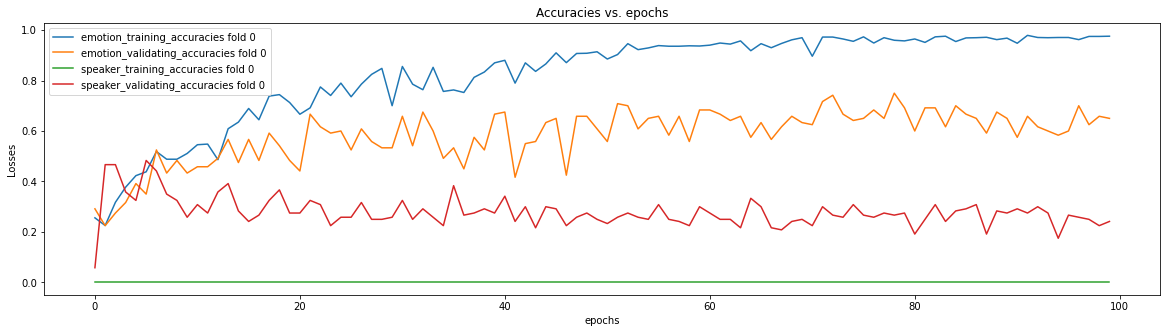

Maximum emotion training accuracy:97.89%
Maximum emotion validating accuracy:75.00%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:48.33%


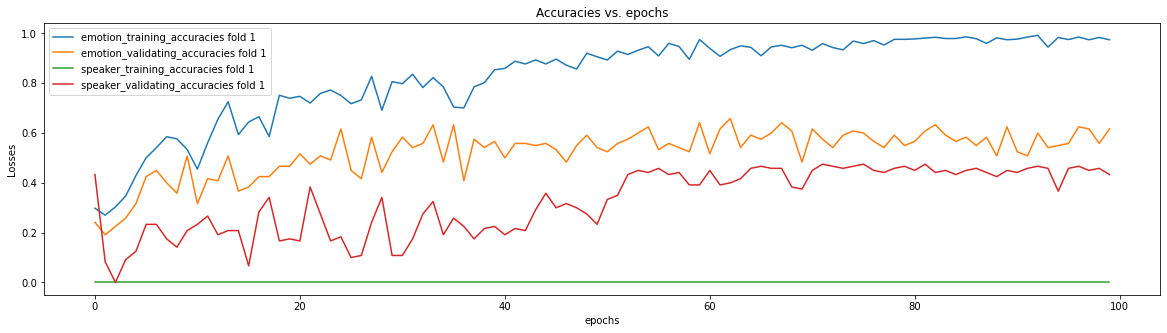

Maximum emotion training accuracy:99.24%
Maximum emotion validating accuracy:65.83%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:47.50%


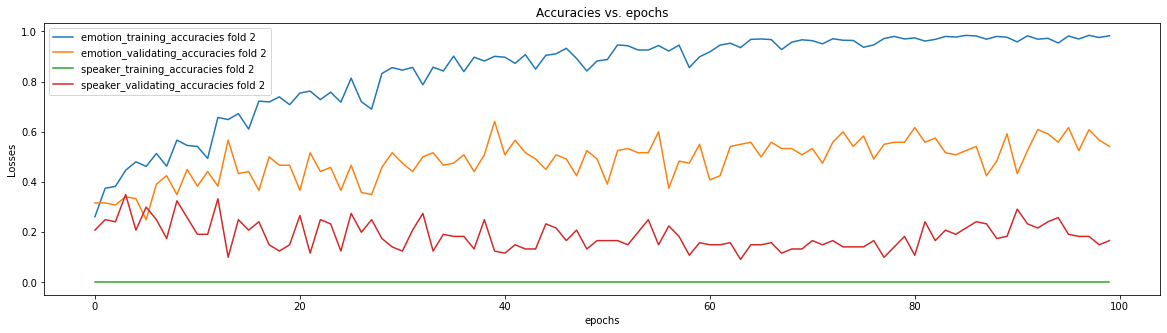

Maximum emotion training accuracy:98.40%
Maximum emotion validating accuracy:64.17%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:35.00%


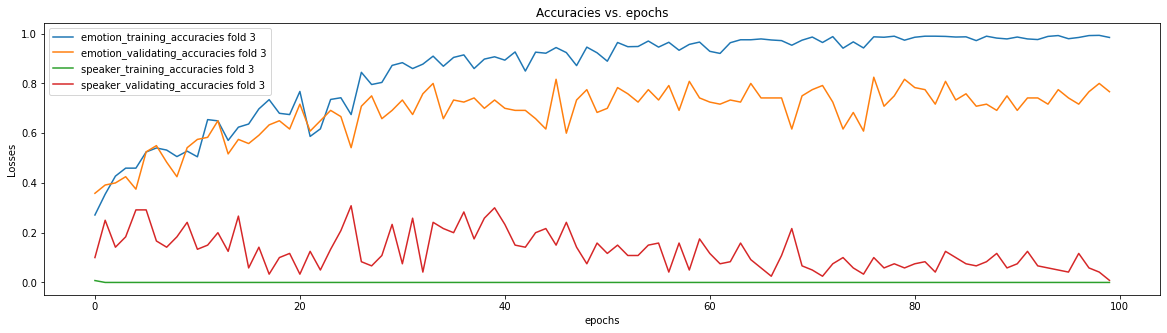

Maximum emotion training accuracy:99.32%
Maximum emotion validating accuracy:82.50%
Maximum speaker training accuracy:0.76%
Maximum speaker validating accuracy:30.83%


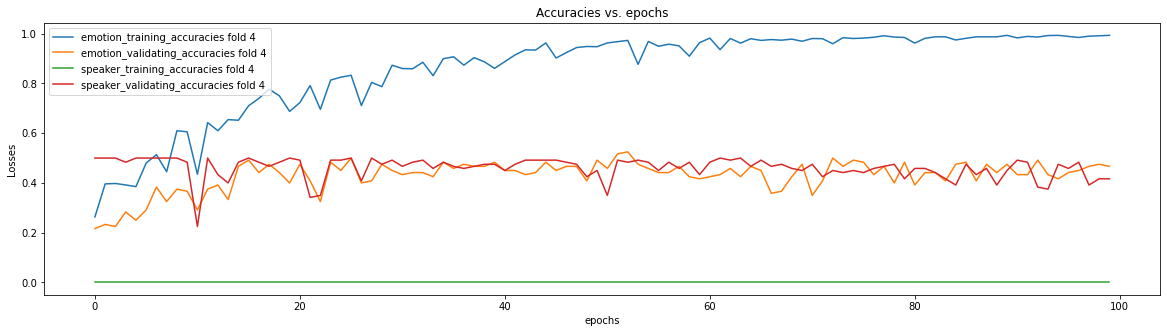

Maximum emotion training accuracy:99.32%
Maximum emotion validating accuracy:52.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


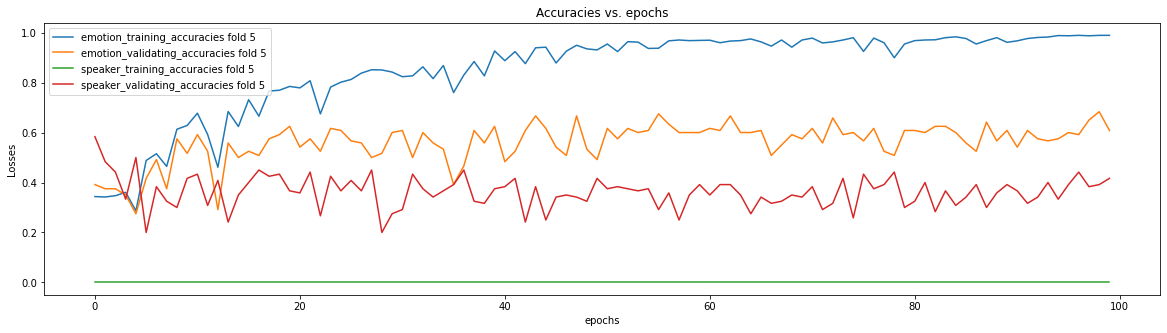

Maximum emotion training accuracy:98.90%
Maximum emotion validating accuracy:68.33%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:58.33%


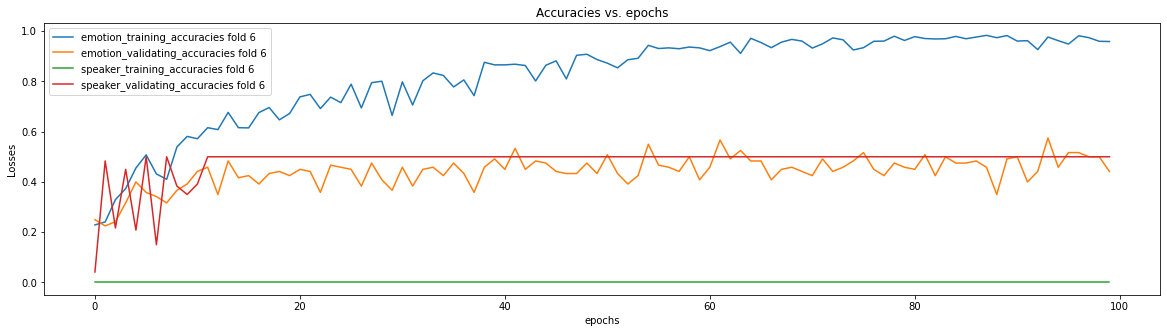

Maximum emotion training accuracy:98.31%
Maximum emotion validating accuracy:57.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


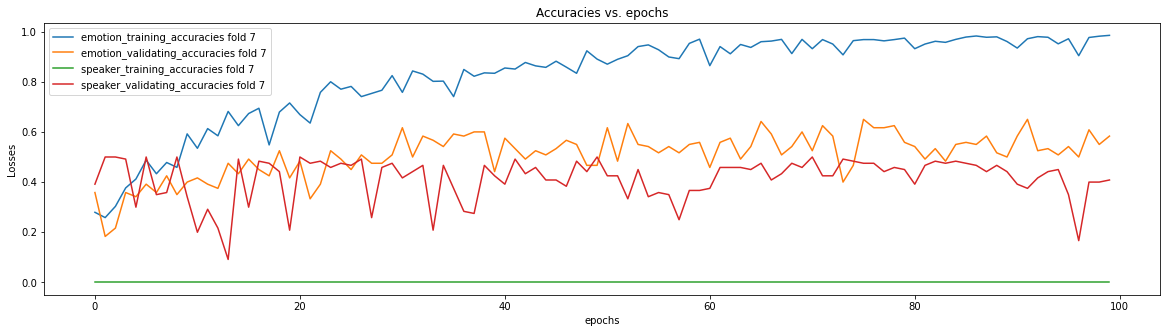

Maximum emotion training accuracy:98.48%
Maximum emotion validating accuracy:65.00%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


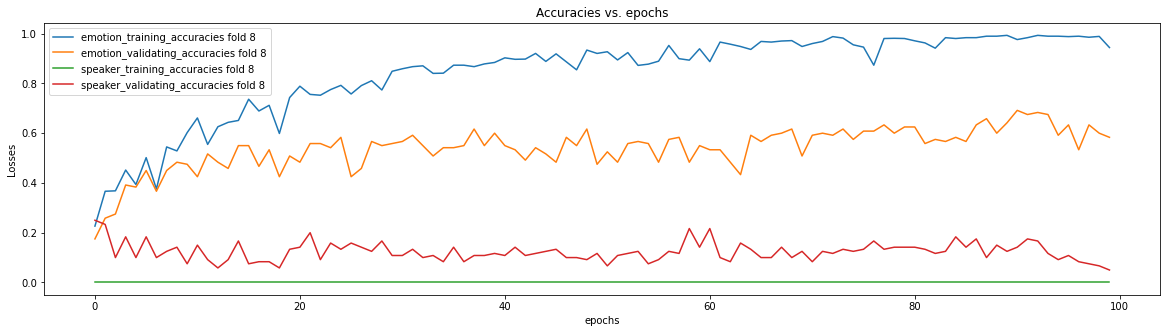

Maximum emotion training accuracy:99.32%
Maximum emotion validating accuracy:69.17%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:25.00%


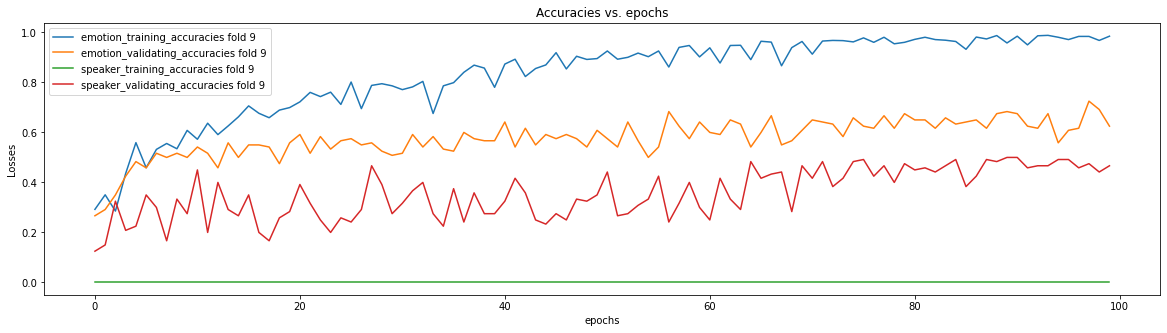

Maximum emotion training accuracy:98.82%
Maximum emotion validating accuracy:72.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


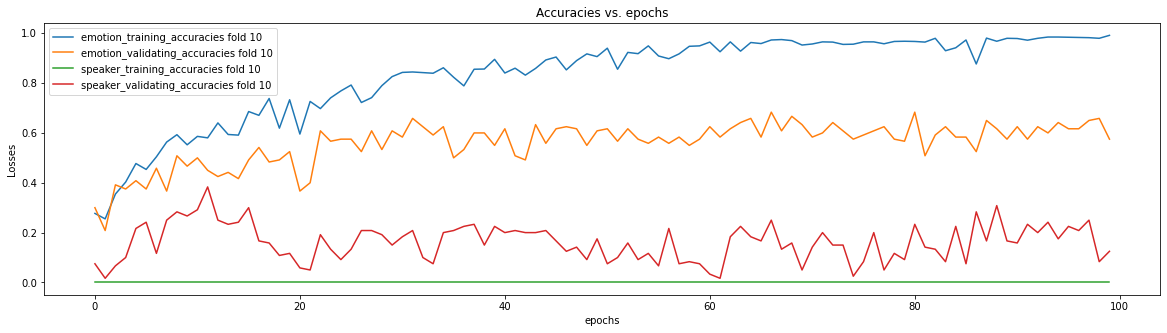

Maximum emotion training accuracy:99.16%
Maximum emotion validating accuracy:68.33%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:38.33%


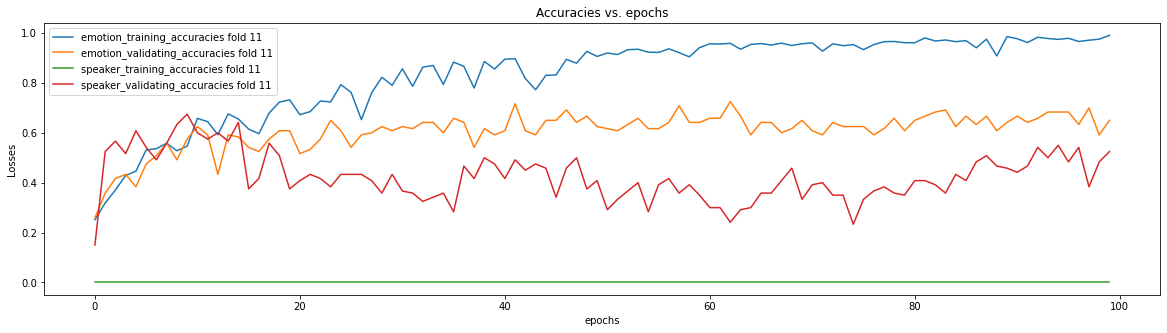

Maximum emotion training accuracy:99.07%
Maximum emotion validating accuracy:72.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:67.50%


In [16]:
for i in range(FOLDS):
    plot_accuracies_vs_epochs(i)

## 5. Loading and evaluating the model

In [17]:
import warnings
warnings.filterwarnings('ignore')
from statistics import mean , stdev


lfold_emotion_training_accuracies, lfold_emotion_validating_accuracies, lfold_emotion_testing_accuracies = [] , [] , []
lfold_speaker_training_accuracies, lfold_speaker_validating_accuracies, lfold_speaker_testing_accuracies = [] , [] , []

for fold in range(12):
    print("\nEvaluation for fold {}".format(fold))
    checkpoint = torch.load(MODEL_PATH + 'fold' + str(fold))
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE)

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    emotion_classifier.load_state_dict(checkpoint['emotion_classifier_state_dict'])
    speaker_classifier.load_state_dict(checkpoint['speaker_classifier_state_dict'])
    
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    emotion_optimizer.load_state_dict(checkpoint['emotion_optimizer_state_dict'])
    speaker_optimizer.load_state_dict(checkpoint['speaker_optimizer_state_dict'])
    
    ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = fold ,split= 'train')
    ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = fold, split= 'test')
    ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = fold, split= 'validate')
    
    TRAIN_BATCH_SIZE = len(ravdess_dataset_train)
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    TEST_BATCH_SIZE = len(ravdess_dataset_test)
    
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    
    encoder.eval()
    emotion_classifier.eval()

    lemotion_training_correct, lemotion_validating_correct, lemotion_testing_correct = 0 , 0 , 0
    lspeaker_training_correct, lspeaker_validating_correct, lspeaker_testing_correct = 0 , 0 , 0

    with torch.no_grad():
        

        # 1. Training Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_train_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_training_correct += (emotion_preds == emotion).sum() 
            lspeaker_training_correct += (speaker_preds == speaker).sum()
        emotion_training_accuracy = lemotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
        speaker_training_accuracy = lspeaker_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
        print("\nEmotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(lemotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
        print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(lspeaker_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100)) 
        
        # 2. Validating Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_validating_correct += (emotion_preds == emotion).sum() 
            lspeaker_validating_correct += (speaker_preds == speaker).sum()
        emotion_validating_accuracy = lemotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
        speaker_validating_accuracy = lspeaker_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
        print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(lemotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
        print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(lspeaker_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100)) 
        

        # 3. Testing Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_test_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_testing_correct += (emotion_preds == emotion).sum() 
            lspeaker_testing_correct += (speaker_preds == speaker).sum()
        emotion_testing_accuracy = lemotion_testing_correct.item()/(len(ravdess_test_loader)*TEST_BATCH_SIZE)
        speaker_testing_accuracy = lspeaker_testing_correct.item()/(len(ravdess_test_loader)*TEST_BATCH_SIZE)
        print("\nEmotion Testing Correct: {}/{} \nEmotion Testing Accuracy: {:.5f}%".format(lemotion_testing_correct,(len(ravdess_test_loader)*TEST_BATCH_SIZE),emotion_testing_accuracy*100))
        print("Speaker Testing Correct: {}/{} \nSpeaker Testing Accuracy: {:.5f}%".format(lspeaker_testing_correct,(len(ravdess_test_loader)*TEST_BATCH_SIZE),speaker_testing_accuracy*100)) 

        lfold_emotion_training_accuracies.append(emotion_training_accuracy)
        lfold_emotion_validating_accuracies.append(emotion_validating_accuracy)
        lfold_emotion_testing_accuracies.append(emotion_testing_accuracy)
        lfold_speaker_training_accuracies.append(speaker_training_accuracy)
        lfold_speaker_validating_accuracies.append(speaker_validating_accuracy)
        lfold_speaker_testing_accuracies.append(speaker_testing_accuracy)

print('\nSUMMARY:')
print('\nCV Emotion Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_training_accuracies), stdev(lfold_emotion_training_accuracies)))
print('\nCV Emotion Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_validating_accuracies), stdev(lfold_emotion_validating_accuracies)))
print('\nCV Emotion Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_testing_accuracies), stdev(lfold_emotion_testing_accuracies)))

print('\nCV Speaker Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_training_accuracies), stdev(lfold_speaker_training_accuracies)))
print('\nCV Speaker Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_validating_accuracies), stdev(lfold_speaker_validating_accuracies)))
print('\nCV Speaker Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_testing_accuracies), stdev(lfold_speaker_testing_accuracies)))


Evaluation for fold 0

Emotion Training Correct: 1151/1200 
Emotion Training Accuracy: 95.91667%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 90/120 
Emotion Validating Accuracy: 75.00000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Emotion Testing Correct: 75/120 
Emotion Testing Accuracy: 62.50000%
Speaker Testing Correct: 16/120 
Speaker Testing Accuracy: 13.33333%

Evaluation for fold 1

Emotion Training Correct: 1122/1200 
Emotion Training Accuracy: 93.50000%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Emotion Testing Correct: 70/120 
Emotion Testing Accuracy: 58.33333%
Speaker Testing Correct: 9/120 
Speaker Testing Accuracy: 7.50000%

Evaluation for fold 2

Emotion Training Correct: 1081/1200 
Emotion Training Accuracy